In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
def print_error_matrix(y_test,y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                annot=True, fmt='g',
                cmap='coolwarm')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()


def plot_ROC(fpr,tpr,roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def evaluate_model_on_folds(model, folds=5, prefix="data/fold_", scaler="MinMaxScaler"):
    metrics = {
        'acc': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'specificity': [],
        'mcc': [],
        'nMCC': [],
        'fc': []
    }

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test.csv")

        # Binarization
        train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)
        test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)

        if scaler == "MinMaxScaler":
            scaler_obj = MinMaxScaler()
        else:
            test['arrytmia'] = test['arrytmia'].apply(lambda x: -1 if x == 0 else x)
            train['arrytmia'] = train['arrytmia'].apply(lambda x: -1 if x == 0 else x)
            scaler_obj = StandardScaler()

        X_train = train.iloc[:, 1:]
        y_train = train['arrytmia'].values

        X_test = test.iloc[:, 1:]
        y_test = test['arrytmia'].values

        X_train = pd.DataFrame(scaler_obj.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler_obj.transform(X_test), columns=X_test.columns)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

        mcc = matthews_corrcoef(y_test, y_pred)
        nMCC = (mcc + 1) / 2

        fc = 0.5 * f1 + 0.3 * specificity + 0.2 * nMCC

        metrics['acc'].append(acc)
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
        metrics['mcc'].append(mcc)
        metrics['nMCC'].append(nMCC)
        metrics['fc'].append(fc)

    def mean_std_str(metric_list):
        mean = np.mean(metric_list)
        std = np.std(metric_list)
        return f"{mean:.2f} $\pm$ {std:.2f}"

    print(f"Accuracy:     {mean_std_str(metrics['acc'])}")
    print(f"Specificity:  {mean_std_str(metrics['specificity'])}")
    print(f"F1-score:     {mean_std_str(metrics['f1'])}")
    # print(f"Precision:    {mean_std_str(metrics['precision'])}")
    # print(f"Sensitivity:  {mean_std_str(metrics['recall'])}")
    # print(f"MCC:          {mean_std_str(metrics['mcc'])}")
    print(f"nMCC:         {mean_std_str(metrics['nMCC'])}")
    print(f"Funkcja celu: {mean_std_str(metrics['fc'])}")

## KNN

In [28]:
knn = KNeighborsClassifier(n_neighbors=50)
evaluate_model_on_folds(knn)


Accuracy:     0.83 $\pm$ 0.01
Specificity:  0.74 $\pm$ 0.03
F1-score:     0.87 $\pm$ 0.01
nMCC:         0.82 $\pm$ 0.01
Funkcja celu: 0.82 $\pm$ 0.01


## DecisionTree

In [29]:
Dtree = DecisionTreeClassifier(max_depth=30)  
evaluate_model_on_folds(Dtree)

Accuracy:     0.83 $\pm$ 0.01
Specificity:  0.77 $\pm$ 0.02
F1-score:     0.86 $\pm$ 0.00
nMCC:         0.83 $\pm$ 0.01
Funkcja celu: 0.83 $\pm$ 0.01


## RandomForest

In [4]:
Rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
evaluate_model_on_folds(Rforest)

Accuracy:     0.84 $\pm$ 0.01
Specificity:  0.72 $\pm$ 0.03
F1-score:     0.87 $\pm$ 0.01
nMCC:         0.83 $\pm$ 0.01
Funkcja celu: 0.82 $\pm$ 0.01


## SVM

## klasyfikator Naive Bayes

In [31]:
NBayes = GaussianNB()
evaluate_model_on_folds(NBayes)

Accuracy:     0.50 $\pm$ 0.04
Specificity:  0.33 $\pm$ 0.28
F1-score:     0.57 $\pm$ 0.17
nMCC:         0.47 $\pm$ 0.02
Funkcja celu: 0.48 $\pm$ 0.01


## XGBoost

In [32]:
XGBoost = xgb.XGBClassifier()
evaluate_model_on_folds(XGBoost)

Accuracy:     0.86 $\pm$ 0.01
Specificity:  0.81 $\pm$ 0.02
F1-score:     0.89 $\pm$ 0.01
nMCC:         0.86 $\pm$ 0.01
Funkcja celu: 0.86 $\pm$ 0.01


## LightGBM

In [33]:
LightGBM = lgb.LGBMClassifier(verbose=-1)
evaluate_model_on_folds(LightGBM)

Accuracy:     0.85 $\pm$ 0.01
Specificity:  0.78 $\pm$ 0.03
F1-score:     0.88 $\pm$ 0.01
nMCC:         0.84 $\pm$ 0.01
Funkcja celu: 0.84 $\pm$ 0.01


## CatBoost

In [34]:
CatB = CatBoostClassifier(verbose=0)
evaluate_model_on_folds(CatB)

Accuracy:     0.86 $\pm$ 0.01
Specificity:  0.81 $\pm$ 0.02
F1-score:     0.89 $\pm$ 0.01
nMCC:         0.86 $\pm$ 0.01
Funkcja celu: 0.86 $\pm$ 0.01


## Neural Network

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    matthews_corrcoef, roc_curve, auc, confusion_matrix
)
import matplotlib.pyplot as plt

def evaluate_given_keras_model(model_builder, scheduler=None, folds=5, prefix="data/fold_", epochs=10, batch_size=32, thresholds=[0.5]):
    auc_scores = []
    all_y_true = []
    all_y_pred_prob = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test.csv")

        train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)
        test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)

        scaler = MinMaxScaler()
        train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
        test = pd.DataFrame(scaler.transform(test), columns=test.columns)

        X_train = train.iloc[:, 1:].values
        y_train = train['arrytmia'].values
        X_test = test.iloc[:, 1:].values
        y_test = test['arrytmia'].values

        model = model_builder(X_train.shape[1])
        callbacks = [scheduler] if scheduler else []

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)
        y_pred_prob = model.predict(X_test).ravel()

        all_y_pred_prob.append(y_pred_prob)
        all_y_true.append(y_test)

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_scores.append(auc(fpr, tpr))

    print("\nWyniki dla różnych wartości threshold:")

    all_y_true = np.concatenate(all_y_true)
    all_y_pred_prob = np.concatenate(all_y_pred_prob)

    for thresh in thresholds:
        accuracies, f1s, precisions, recalls, specificities, mccs, n_mccs, fcs = [], [], [], [], [], [], [], []

        start = 0
        for i in range(folds):
            fold_len = len(all_y_true) // folds
            end = start + fold_len if i < folds - 1 else len(all_y_true)

            y_true_fold = all_y_true[start:end]
            y_prob_fold = all_y_pred_prob[start:end]
            y_pred_fold = (y_prob_fold >= thresh).astype(int)

            cm = confusion_matrix(y_true_fold, y_pred_fold, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()

            acc = accuracy_score(y_true_fold, y_pred_fold)
            f1 = f1_score(y_true_fold, y_pred_fold, zero_division=0)
            prec = precision_score(y_true_fold, y_pred_fold, zero_division=0)
            rec = recall_score(y_true_fold, y_pred_fold, zero_division=0)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            mcc = matthews_corrcoef(y_true_fold, y_pred_fold)
            n_mcc = (mcc + 1) / 2
            fc = 0.5 * f1 + 0.3 * spec + 0.2 * n_mcc

            accuracies.append(acc)
            f1s.append(f1)
            precisions.append(prec)
            recalls.append(rec)
            specificities.append(spec)
            mccs.append(mcc)
            n_mccs.append(n_mcc)
            fcs.append(fc)

            start = end

        def mean_std_str(metric_list):
            return f"{np.mean(metric_list):.2f} ± {np.std(metric_list):.2f}"

        print(f"\nThreshold = {thresh}")
        print(f"Accuracy:     {mean_std_str(accuracies)}")
        print(f"F1-score:     {mean_std_str(f1s)}")
        print(f"Precision:    {mean_std_str(precisions)}")
        print(f"Sensitivity:  {mean_std_str(recalls)}")
        print(f"Specificity:  {mean_std_str(specificities)}")
        print(f"MCC:          {mean_std_str(mccs)}")
        print(f"nMCC:         {mean_std_str(n_mccs)}")
        print(f"Funkcja celu: {mean_std_str(fcs)}")

    mean_auc = np.mean(auc_scores)
    print(f"\nŚredni AUC: {mean_auc:.2f}")

    # Średnia krzywa ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Średnia krzywa ROC (5-fold)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step

Wyniki dla różnych wartości threshold:

Threshold = 0.3
Accuracy:     0.80 ± 0.01
F1-score:     0.85 ± 0.01
Precision:    0.77 ± 0.02
Sensitivity:  0.95 ± 0.01
Specificity:  0.57 ± 0.04
MCC:          0.59 ± 0.02
nMCC:         0.79 ± 0.01
Funkcja celu: 0.76 ± 0.02

Threshold = 0.5
Accuracy:     0.82 ± 0.01
F1-score:     0.85 ± 0.01
Precision:    0.84 ± 0.02
Sensitivity:  0.88 ± 0.04
Specificity:  0.73 ± 0.05
MCC:          0.62 ± 0.02
nMCC:         0.81 ± 0.01
Funkcja celu: 0.81 ± 0.02

Threshold = 0.7
Accuracy:     0.81 ± 0.02
F1-score:     0.83 ± 0.03
Precision:    0.88 ± 0.02
Sensitivity:  0.78 ± 0.06
Specificity:  0.84 ± 0.04
MCC:          0.61 ± 0.03
nMCC:         0.81 ± 0.02
Funkcja celu: 0.83 ± 0.01

Średni AUC: 0.89


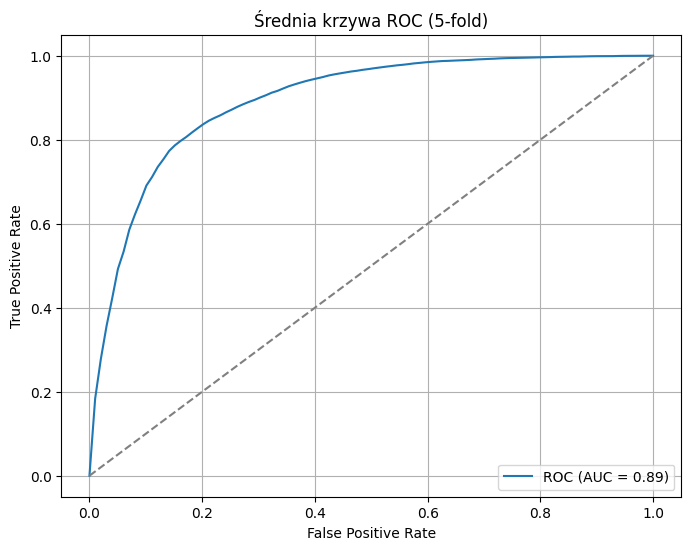

In [5]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation='relu'), 
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'), 
        layers.Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler, epochs=10, batch_size=64)


In [11]:
SVM = SVC(kernel='rbf')
evaluate_model_on_folds(SVM,scaler="inny")

Accuracy:     0.79 $\pm$ 0.01
Specificity:  0.61 $\pm$ 0.03
F1-score:     0.84 $\pm$ 0.01
nMCC:         0.78 $\pm$ 0.01
Funkcja celu: 0.76 $\pm$ 0.01


In [5]:
from neo_ls_svm import NeoLSSVM

model = NeoLSSVM()
evaluate_model_on_folds(model,scaler="inny")


Accuracy:     0.78 $\pm$ 0.01
Specificity:  0.61 $\pm$ 0.02
F1-score:     0.83 $\pm$ 0.01
nMCC:         0.76 $\pm$ 0.01
Funkcja celu: 0.75 $\pm$ 0.01
